In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
dir = os.getcwd()
project_root = os.path.abspath(os.path.join(dir, '..'))
data_root = os.path.join(project_root, 'data')
df = pd.read_parquet(path=os.path.join(data_root, 'f1_2025_telemetry.parquet'), engine='pyarrow')
df['Brake'] = df['Brake'].astype(int)
df.describe()

,RoundNumber,LapNumber,DriverNumber,Speed,RPM,nGear,Throttle,Brake
count,1.647400e+07,1.647400e+07,1.647400e+07,1.647400e+07,1.647400e+07,1.647400e+07,1.647400e+07,1.647400e+07
mean,1.221340e+01,3.007938e+01,2.939126e+01,1.984771e+02,1.004194e+04,5.061306e+00,6.183883e+01,2.092591e-01
std,6.758258e+00,1.830824e+01,2.485243e+01,7.341953e+01,1.603750e+03,1.900817e+00,4.237759e+01,4.067797e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,1.400000e+01,1.000000e+01,1.356000e+02,9.192000e+03,3.000000e+00,7.299998e+00,0.000000e+00
50%,1.200000e+01,2.900000e+01,2.200000e+01,2.020000e+02,1.065900e+04,5.000000e+00,8.364000e+01,0.000000e+00
75%,1.800000e+01,4.500000e+01,4.400000e+01,2.610000e+02,1.118700e+04,7.000000e+00,1.000000e+02,0.000000e+00
max,2.400000e+01,7.800000e+01,8.700000e+01,3.650000e+02,1.355500e+04,5.700000e+01,1.040000e+02,1.000000e+00


In [5]:
df.head()

,RoundNumber,LapNumber,DriverNumber,Speed,RPM,nGear,Throttle,Brake
0,1,1,1,0.0,10114,2,16.0,1
1,1,1,1,0.0,10043,2,16.0,1
2,1,1,1,0.0,9964,2,16.0,1
3,1,1,1,0.0,9752,2,16.0,1
4,1,1,1,0.0,8520,2,16.0,1


In [6]:
df = df[df['LapNumber'] != 1] 

In [7]:
df.isna().sum()

RoundNumber     0
LapNumber       0
DriverNumber    0
Speed           0
RPM             0
nGear           0
Throttle        0
Brake           0
dtype: int64

In [8]:
df_agg = df[['RoundNumber', 'LapNumber', 'DriverNumber']].drop_duplicates()
cornering_speed = df[df['Speed'] < 150]
avg_cornering = cornering_speed.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['Speed'].mean().reset_index()
df_agg = df_agg.merge(avg_cornering, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg[df_agg['Speed'].isna()]

,RoundNumber,LapNumber,DriverNumber,Speed
2861,4,46,63,NaN
2862,4,47,63,NaN
2863,4,48,63,NaN
2864,4,49,63,NaN
2865,4,50,63,NaN
2866,4,51,63,NaN
2867,4,52,63,NaN
2868,4,53,63,NaN
2869,4,54,63,NaN
2870,4,55,63,NaN


In [9]:
df_agg.query('RoundNumber == 4 and LapNumber >= 44 and LapNumber <= 60 and DriverNumber == 63')

,RoundNumber,LapNumber,DriverNumber,Speed
2859,4,44,63,110.796509
2860,4,45,63,103.517258
2861,4,46,63,NaN
2862,4,47,63,NaN
2863,4,48,63,NaN
2864,4,49,63,NaN
2865,4,50,63,NaN
2866,4,51,63,NaN
2867,4,52,63,NaN
2868,4,53,63,NaN


In [10]:
df.query('RoundNumber == 4 and LapNumber >= 46 and LapNumber <= 60 and DriverNumber == 63').describe()

,RoundNumber,LapNumber,DriverNumber,Speed,RPM,nGear,Throttle,Brake
count,8757.0,8757.000000,8757.0,8757.0,8757.0,8757.0,8757.0,8757.0
mean,4.0,51.527578,63.0,151.0,11577.0,3.0,104.0,1.0
std,0.0,3.455760,0.0,0.0,0.0,0.0,0.0,0.0
min,4.0,46.000000,63.0,151.0,11577.0,3.0,104.0,1.0
25%,4.0,49.000000,63.0,151.0,11577.0,3.0,104.0,1.0
50%,4.0,52.000000,63.0,151.0,11577.0,3.0,104.0,1.0
75%,4.0,55.000000,63.0,151.0,11577.0,3.0,104.0,1.0
max,4.0,57.000000,63.0,151.0,11577.0,3.0,104.0,1.0


After checking race footage, there was some problems with car no. 63, so that's probably why this data looks so strange. We'll fix that after merging telemetry data with other data that we've obtained so far. For now, let's just see values on those laps to NaN (done after aggregations).

We have to check if our data contains more situations like this. We will do this after aggregation, as checking 16 milion records will take a long time.

In [11]:
def find_frozen_sensors(df, threshold=5):
    check_df = df[['RoundNumber', 'DriverNumber', 'LapNumber', 'Speed']].copy()
    
    check_df = check_df.sort_values(by=['RoundNumber', 'DriverNumber', 'LapNumber'])
    check_df['group_id'] = (check_df['Speed'] != check_df['Speed'].shift()).cumsum()

    frozen_groups = check_df.groupby(['RoundNumber', 'DriverNumber', 'Speed', 'group_id']).size().reset_index(name='count')

    anomalies = frozen_groups[frozen_groups['count'] >= threshold]

    results = []
    
    for _, row in anomalies.iterrows():
        details = check_df[check_df['group_id'] == row['group_id']]
        
        start_lap = details['LapNumber'].min()
        end_lap = details['LapNumber'].max()
        
        results.append({
            'Round': int(row['RoundNumber']),
            'Driver': int(row['DriverNumber']),
            'StuckValue': row['Speed'],
            'Duration_Samples': row['count'],
            'StartLap': start_lap,
            'EndLap': end_lap,
        })

    return pd.DataFrame(results)

stuck_sensors_df = find_frozen_sensors(df_agg, threshold=5)

if not stuck_sensors_df.empty:
    print(stuck_sensors_df.sort_values('Duration_Samples', ascending=False)[['Round', 'Driver', 'StartLap', 'EndLap']].to_string(index=False))

 Round  Driver  StartLap  EndLap
    16      23         2      11


In [12]:
max_speed = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['Speed'].max().reset_index()
df_agg = df_agg.merge(max_speed, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
dtype: int64

In [13]:
mean_rpm = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['RPM'].mean().reset_index()
df_agg = df_agg.merge(mean_rpm, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
RPM              0
dtype: int64

In [14]:
gear_shift_func = lambda x: (x.diff().fillna(0) != 0).sum()
gear_shifts = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['nGear'].agg(gear_shift_func).reset_index()
df_agg = df_agg.merge(gear_shifts, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
RPM              0
nGear            0
dtype: int64

Let's just add that I'm very sceptical about this feature (GearShifts), but more about it in the analysis part.

In [15]:
avg_throttle = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['Throttle'].mean().reset_index()
df_agg = df_agg.merge(avg_throttle, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
RPM              0
nGear            0
Throttle         0
dtype: int64

In [16]:
brake_pct = df.groupby(by=['RoundNumber', 'LapNumber', 'DriverNumber'])['Brake'].mean().reset_index()
brake_pct['Brake'] = brake_pct['Brake'] * 100
df_agg = df_agg.merge(brake_pct, how='left', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg.isna().sum()

RoundNumber      0
LapNumber        0
DriverNumber     0
Speed_x         12
Speed_y          0
RPM              0
nGear            0
Throttle         0
Brake            0
dtype: int64

In [17]:
df_agg = df_agg.rename(columns={
    'Speed_x': 'AvgCorneringSpeed',
    'Speed_y': 'MaxSpeed',
    'RPM': 'AvgRPM',
    'nGear': 'GearShifts',
    'Throttle': 'AvgThrottle',
    'Brake': 'BrakePct'
})
df_agg.head()

,RoundNumber,LapNumber,DriverNumber,AvgCorneringSpeed,MaxSpeed,AvgRPM,GearShifts,AvgThrottle,BrakePct
0,1,6,1,106.860840,259.00000,9501.549296,62,36.008251,32.676056
1,1,7,1,103.675873,282.53125,9353.190751,51,36.403046,29.672447
2,1,8,1,113.707870,306.00000,10227.545209,43,58.098125,24.021592
3,1,9,1,114.044373,307.00000,10194.761970,42,59.435406,22.161423
4,1,10,1,114.278442,308.00000,10258.565341,38,61.929466,20.738636


In [18]:
def scan_for_anomalies(df, threshold=5):    

    # we don't check for GearShifts and MaxSpeed, as this values are higly probable to repeat themselves
    features_to_check = ['AvgCorneringSpeed', 'AvgRPM', 'AvgThrottle', 'BrakePct']
    
    check_df = df.sort_values(by=['RoundNumber', 'DriverNumber', 'LapNumber']).copy()
    
    all_anomalies = []

    for col in features_to_check:
        group_ids = (check_df[col] != check_df[col].shift()).cumsum()
        
        groups = check_df.groupby(['RoundNumber', 'DriverNumber', group_ids])
        
        check_df['group_size'] = groups[col].transform('size')
        
        suspects = check_df[check_df['group_size'] >= threshold].copy()
        
        if suspects.empty:
            continue
            
        suspects['group_id'] = group_ids[suspects.index]
        
        unique_errors = suspects.groupby(['RoundNumber', 'DriverNumber', 'group_id'])
        
        for (round_num, driver_num, _), group_data in unique_errors:
            count = len(group_data)
            start_lap = group_data['LapNumber'].min()
            end_lap = group_data['LapNumber'].max()

            all_anomalies.append({
                'Feature': col,              
                'Round': int(round_num),
                'Driver': int(driver_num),
                'Laps_Count': count,        
                'StartLap': int(start_lap),
                'EndLap': int(end_lap)
            })

    if not all_anomalies:
        print('No anomalies detected')
        return pd.DataFrame()
    else:
        result_df = pd.DataFrame(all_anomalies)
        result_df = result_df.sort_values(by=['Laps_Count'], ascending=False)
        
        print(f'Found {len(result_df)} different errors')
        return result_df

errors_df = scan_for_anomalies(df_agg, threshold=5)

if not errors_df.empty:
    print(errors_df.to_string(index=False))

Found 7 different errors
          Feature  Round  Driver  Laps_Count  StartLap  EndLap
           AvgRPM      4      63          12        46      57
         BrakePct      4      63          12        46      57
      AvgThrottle      4      63          12        46      57
AvgCorneringSpeed     16      23          10         2      11
           AvgRPM     16      23           9         2      10
      AvgThrottle     16      23           9         2      10
         BrakePct     16      23           9         2      10


In [19]:
df_agg.query('RoundNumber == 16 and LapNumber >= 0 and LapNumber <= 20 and DriverNumber == 23')

,RoundNumber,LapNumber,DriverNumber,AvgCorneringSpeed,MaxSpeed,AvgRPM,GearShifts,AvgThrottle,BrakePct
15740,16,2,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15741,16,3,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15742,16,4,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15743,16,5,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15744,16,6,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15745,16,7,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15746,16,8,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15747,16,9,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15748,16,10,23,0.000000,0.0,0.000000,0,0.000000,0.000000
15749,16,11,23,0.000000,337.0,5208.604615,16,38.467052,6.153846


In [20]:
def set_sensor_error_nan(df, round, driver, laps, cols_to_fix):
    mask_broken = (
    (df['RoundNumber'] == round) & 
    (df['DriverNumber'] == driver) & 
    (df['LapNumber'].between(laps[0], laps[1]))
)

    df.loc[mask_broken, cols_to_fix] = np.nan
    return df

cols_to_fix = ['AvgCorneringSpeed', 'MaxSpeed', 'AvgRPM', 'GearShifts', 'AvgThrottle', 'BrakePct'] 

df_agg = set_sensor_error_nan(df_agg, 4, 63, (45, 57), cols_to_fix)
df_agg = set_sensor_error_nan(df_agg, 16, 23, (2, 11), cols_to_fix)

In [21]:
df_agg_train = df_agg[df_agg['RoundNumber'] < 19].copy()
df_agg_test = df_agg[df_agg['RoundNumber'] >= 19].copy()

In [22]:
df_train = pd.read_csv(filepath_or_buffer=os.path.join(data_root, 'f1_train.csv'))
target = df_train[['RoundNumber', 'LapNumber', 'DriverNumber', 'Target']]
df_agg_train = df_agg_train.merge(target, how='inner', on=['RoundNumber', 'LapNumber', 'DriverNumber'])
df_agg_train

,RoundNumber,LapNumber,DriverNumber,AvgCorneringSpeed,MaxSpeed,AvgRPM,GearShifts,AvgThrottle,BrakePct,Target
0,1,8,1,113.707870,306.0,10227.545209,43.0,58.098125,24.021592,1.289416
1,1,9,1,114.044373,307.0,10194.761970,42.0,59.435406,22.161423,1.255926
2,1,10,1,114.278442,308.0,10258.565341,38.0,61.929466,20.738636,1.233754
3,1,11,1,114.117096,306.0,10178.821023,32.0,63.803638,19.744318,1.231131
4,1,12,1,113.393890,307.0,10133.620056,34.0,63.588581,20.197740,1.219652
...,...,...,...,...,...,...,...,...,...,...
16197,18,57,27,113.255959,308.0,9835.617050,52.0,60.021214,30.717185,1.082842
16198,18,58,27,112.069870,320.0,9749.845950,51.0,57.827679,24.966799,1.099329
16199,18,59,27,112.071701,315.0,9686.645833,53.0,57.720318,30.277778,1.101157
16200,18,60,27,111.066635,315.0,9629.571235,53.0,55.880280,31.071913,1.112396


In [23]:
df_agg_train.corr()['Target'].sort_values(ascending=False)

Target               1.000000
BrakePct             0.216283
AvgCorneringSpeed    0.157753
DriverNumber         0.003870
GearShifts          -0.125948
RoundNumber         -0.134745
MaxSpeed            -0.236546
LapNumber           -0.246140
AvgRPM              -0.277716
AvgThrottle         -0.334208
Name: Target, dtype: float64

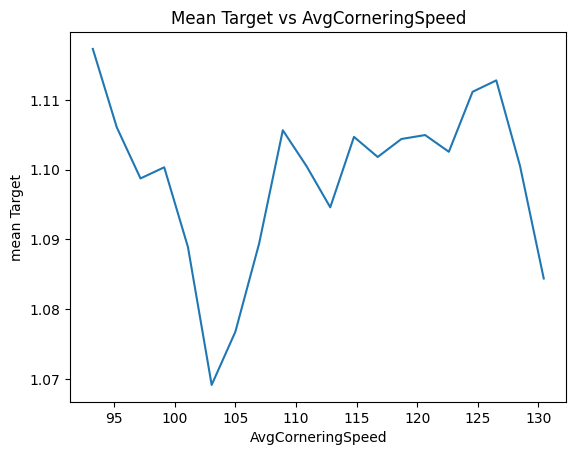

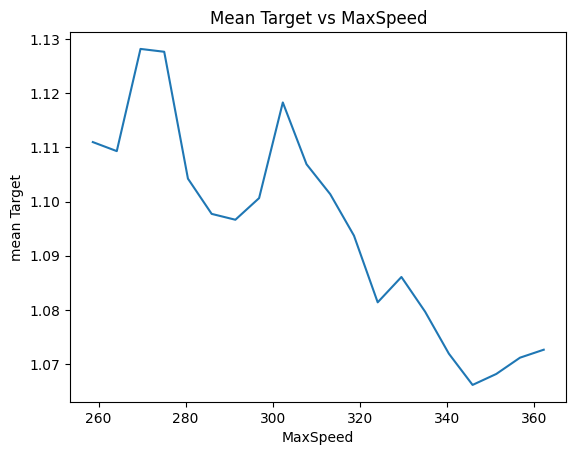

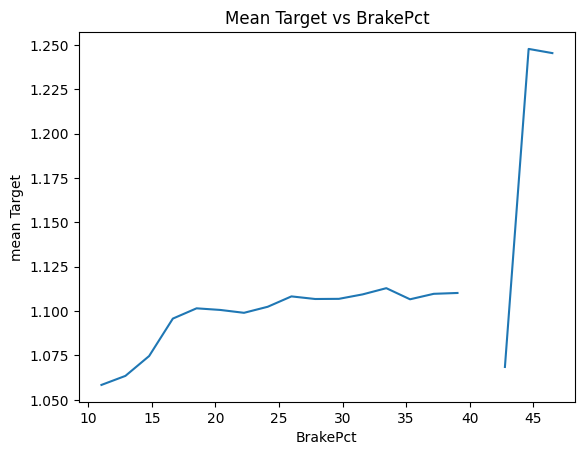

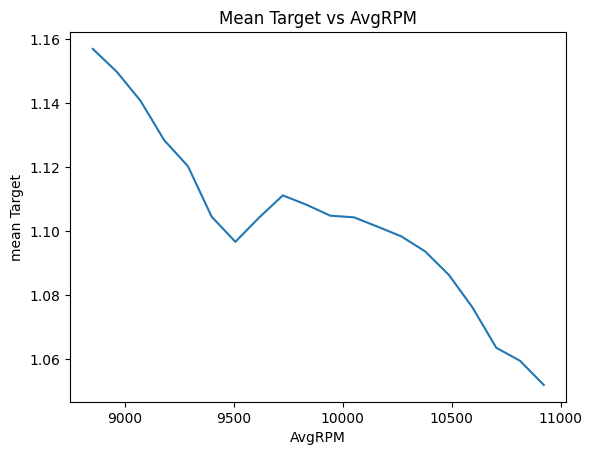

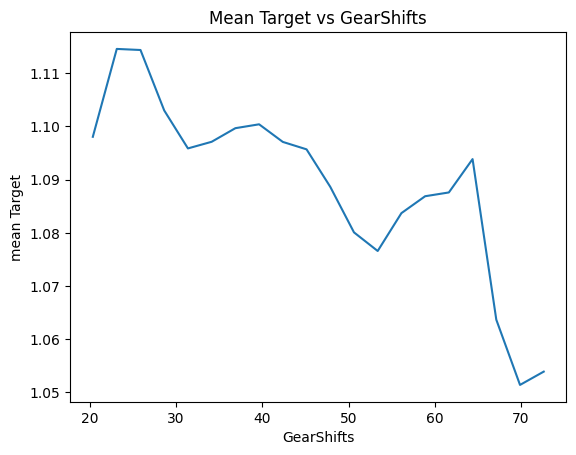

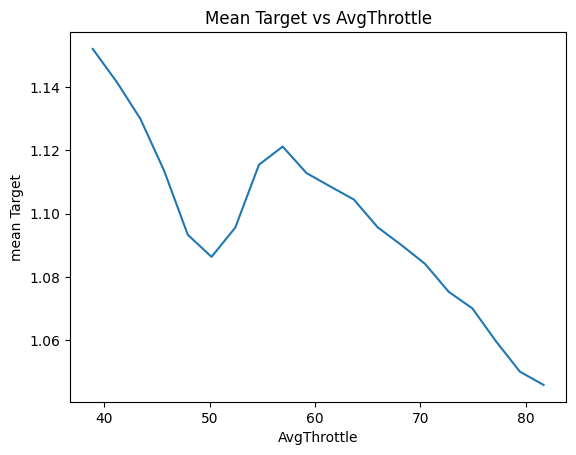

In [24]:
def trend(df, xcol, ycol="Target", bins=20, title=None):
    b = pd.cut(df[xcol], bins=bins)
    g = df.groupby(b, observed=False)[ycol].agg(["mean","count"])
    x = b.cat.categories.mid

    plt.figure()
    plt.plot(x, g["mean"].values)
    plt.title(f"Mean {ycol} vs {xcol}")
    plt.xlabel(xcol)
    plt.ylabel(f"mean {ycol}")
    plt.show()


trend(df_agg_train, "AvgCorneringSpeed")
trend(df_agg_train, "MaxSpeed")
trend(df_agg_train, "BrakePct")
trend(df_agg_train, "AvgRPM")
trend(df_agg_train, "GearShifts")
trend(df_agg_train, "AvgThrottle") 

In [25]:
df_agg.to_csv(os.path.join(data_root, 'f1_telemetry_agg.csv'), index=False)